# Considerações iniciais

Em abril de 2022, a STRANS implementou o Sistema de Notificação Eletrônica (SNE), visando agilizar o processo de notificação de infrações de trânsito por meio de automação. No entanto, o principal beneficiário desse sistema é o infrator, que recebe notificações de maneira mais ágil. Além disso, aqueles que cometem infrações têm a oportunidade de pagar o valor da multa com um desconto de 40%, desde que assumam a infração e abram mão do direito de defesa.

Após mais de um ano e meio da implementação do SNE, é crucial avaliar se houve mudanças nos pagamentos das infrações da STRANS. Antes de iniciar a análise, é fundamental mencionar alguns pontos importantes. Esta avaliação se baseará em uma amostra de dados coletados antes da implementação do SNE. Devido a problemas de sistema, nem todos os dados estavam disponíveis. Para contornar essa questão, foi realizada uma amostragem aleatória de 7260 autos referentes aos anos de 2017 a 2021. Essa amostra representa estatisticamente de forma confiável o período em questão.

Outro ponto crucial a ser considerado é que não podemos usar todo o prazo de pagamento para as infrações. Após o registro da infração, há um limite de até 5 anos para o pagamento, caso não seja feito nesse período, a multa prescreve. Para avaliar o impacto do SNE, usaremos a proporção de multas pagas até 60 dias após o registro, em comparação com aquelas pagas até 426 dias. O valor máximo refere-se ao período máximo obtido após a implementação do SNE e, para maximizar nossos dados anteriores ao SNE, será utilizado como referência.

Por fim, aplicaremos o teste de Kolmogorov-Smirnov (KS) para comparar as distribuições do tempo de pagamento. Apesar da discrepância na quantidade de infrações entre antes e depois da implementação do SNE, o teste KS baseia-se na distribuição acumulada para avaliar as diferenças entre as distribuições, considerando o formato delas ao calcular o valor do teste, e não o número de elementos.

In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np

from scipy import stats
from datetime import date

#configure out of pandas dataframe
pd.options.display.max_colwidth = 150

# setting of the graphics 
from matplotlib import rc
# estilo dos gráficos #https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
plt.style.use('bmh')
%config InlineBackend.figure_format = 'retina'  # image format
rc('font', **{"family":"sans-serif","sans-serif":["DejaVu Sans"], "size":10})

rc('mathtext', **{"default":"regular"})

import warnings
warnings.filterwarnings("ignore")

In [3]:
def load_all_finns_data():
    # Get a list of Excel files in the specified directory
    xlsx_files_all = glob.glob('D:/OneDrive/DEV/pay_SNE/ResultadoConsultaInfracoes*')

    # Create an empty list to store DataFrames
    dataframes_all = []

    # Read each Excel file into a DataFrame and append it to the list
    for file in xlsx_files_all:
        # Skip 5 rows and use row 1 as the header
        df_all = pd.read_excel(file, skiprows=5, header=1, usecols=['N. Auto', 'Valor', 'Pago', 'Cometimento', 'SNE'])
        dataframes_all.append(df_all)

    # Concatenate the DataFrames vertically
    df_all = pd.concat(dataframes_all, ignore_index=True)
    # Convert the 'Cometimento' column to datetime format
    df_all['Cometimento'] = pd.to_datetime(df_all['Cometimento'], format='%d/%m/%Y %H:%M:%S')
    
    return df_all

def load_all_finns_payments():
    # Get a list of Excel files in the specified directory
    xlsx_files_pay = glob.glob('D:/OneDrive/DEV/pay_SNE/ResultadoConsultaPagamentos*')

    # Create an empty list to store DataFrames
    dataframes_pay = []

    # Read each Excel file into a DataFrame and append it to the list
    for file in xlsx_files_pay:
        # Skip 8 rows and use row 1 as the header
        df_pay = pd.read_excel(file, skiprows=8, header=1, usecols=['Número Auto', 'Valor Pago', 'Data Pagamento'])
        dataframes_pay.append(df_pay)

    # Concatenate the DataFrames vertically
    df_pay = pd.concat(dataframes_pay, ignore_index=True)
    # Convert the 'Data Pagamento' column to datetime format
    df_pay['Data Pagamento'] = pd.to_datetime(df_pay['Data Pagamento'], format='%d/%m/%Y')
    
    return df_pay

df_all = load_all_finns_data()
df_pay = load_all_finns_payments()

Os autos analisados após a implantação do SNE correspondem ao período de 07/2022 a 06/2023. Foi dado um intervalo de 3 meses de implantação para diminuir o efeito novidade do sistema na capital. No total, foram 277.569 autos registrados. 

In [4]:
len(df_all)

277569

## Situação de Pagamento

Dos dados do sistema, constata-se que durante o período analisado, 33,12% dos autos foram pagos. Esse valor é comparável ao percentual anterior à implementação do SNE, no qual apenas 40% dos autos eram pagos. Ao longo do tempo, é esperado que a taxa de pagamento se aproxime ou supere os 40%

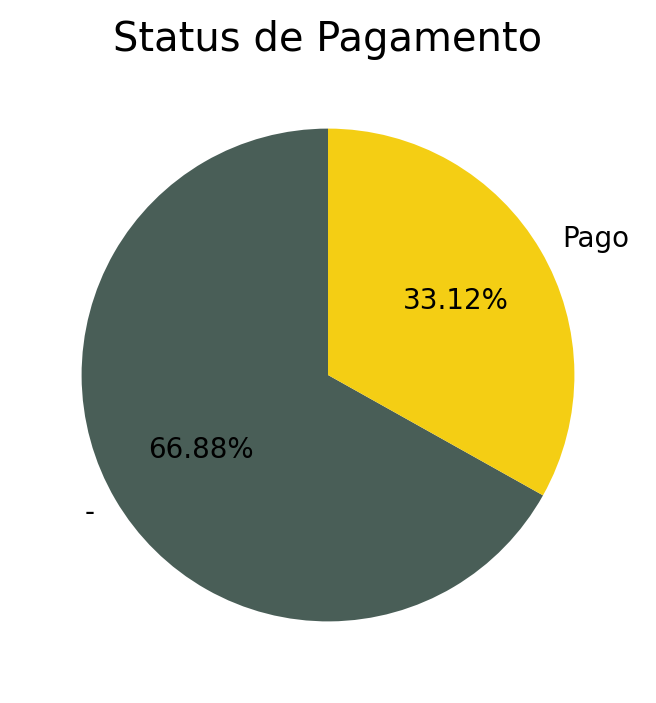

In [5]:
def pie_pay():
    # Get the value counts of the 'Pago' column
    paid_counts = df_all['Pago'].value_counts()

    # Create a pie chart
    plt.figure(figsize=(4,4))
    plt.pie(paid_counts, labels=paid_counts.index, autopct='%.2f%%', startangle=90, colors=['#495E57', '#F4CE14'])
    plt.title('Status de Pagamento')
    plt.show()

pie_pay()

## Adesão ao SNE

Aproximadamente 20% dos veículos autuados aderiram ao SNE. Desenvolvido pelo governo federal, o sistema teve uma adesão gradual pelos órgãos de fiscalização. No estado do Piauí, a STRANS foi a primeira entidade a adotar esse sistema

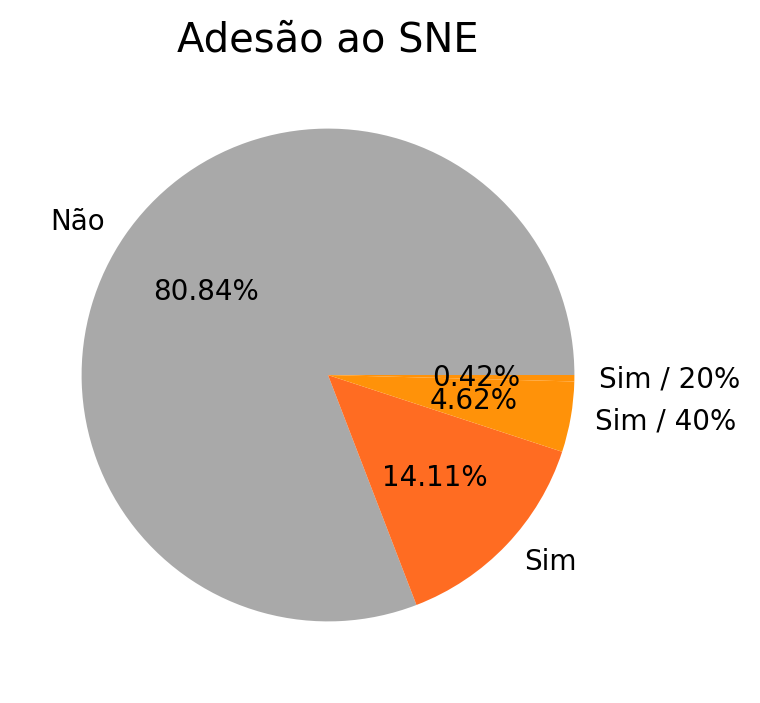

In [6]:
def pie_sne():
    # Get the value counts of the 'Pago' column
    paid_counts = df_all['SNE'].value_counts()

    # Create a pie chart
    plt.figure(figsize=(4,4))
    plt.pie(paid_counts, labels=paid_counts.index, autopct='%.2f%%', colors=['#A9A9A9', '#FF6C22', '#FF9209', '#FF9209'])
    plt.title('Adesão ao SNE')
    plt.show()

pie_sne()

# Situação anterior

É relevante destacar o cenário prévio à implementação do SNE. Os dados utilizados correspondem a uma amostra que oferece uma excelente representação do período. Constatamos que, nesse contexto, apenas 40% dos autos foram pagos.

In [7]:
def loading_file():
    df = pd.read_csv('join_year.csv', index_col=False,  usecols= ['ST_NUMEROAUTO', 'ST_PLACAVEICULO', 'DT_DATAINFRACAO', 'NR_VALOR', 'ST_TIPOVEICULO', 'ST_ESPECIEVEICULO', 'Duplicates','Valor pago','Dia_pagamento'])
    df = df[~pd.isna(df["Valor pago"])]
    df['Valor pago'] = df['Valor pago'].str.replace('R$', '')
    df['Valor pago'] = df['Valor pago'].str.replace('.', '')
    df['Valor pago'] = df['Valor pago'].str.replace(',', '.')
    df['Dia_pagamento'] = df['Dia_pagamento'].str.replace('/', '-')
    df['Dia_pagamento'] = pd.to_datetime(df['Dia_pagamento'], format='%d-%m-%Y', errors='coerce')
    df['Dia_pagamento'] = df['Dia_pagamento'].fillna(date.today())
    df['Dia_pagamento'] = pd.to_datetime(df['Dia_pagamento'])
    df['DT_DATAINFRACAO'] = pd.to_datetime(df['DT_DATAINFRACAO'])
    df['Periodo pagamento'] = (df['Dia_pagamento'] - df['DT_DATAINFRACAO']).dt.days
    df.iloc[29, 7] = 880.4
    df['Valor pago']  = pd.to_numeric(df['Valor pago'])
    df.loc[df['Valor pago'] <1 , 'Status'] = 0
    df.loc[df['Valor pago'] >=1 , 'Status'] = 1
    replace_dict = {6: 'Automóvel', 4: 'Motocicleta', 23: 'Caminhonete', 13:'Camioneta', 3:'Motoneta', 25:'Utilitário'}
    df['ST_TIPOVEICULO'] = df['ST_TIPOVEICULO'].replace(replace_dict)
    df['ST_TIPOVEICULO'] = df['ST_TIPOVEICULO'].replace({'Motocicleta': 'Moto', 'Motoneta': 'Moto'})
    df.loc[~df['ST_TIPOVEICULO'].isin(['Automóvel', 'Moto']), 'ST_TIPOVEICULO'] = 'Outros'
    
    df['Periodo pagamento'] = df['Periodo pagamento'].apply(lambda x: 1825 if x > 1825 else x)
    return df

df = loading_file()

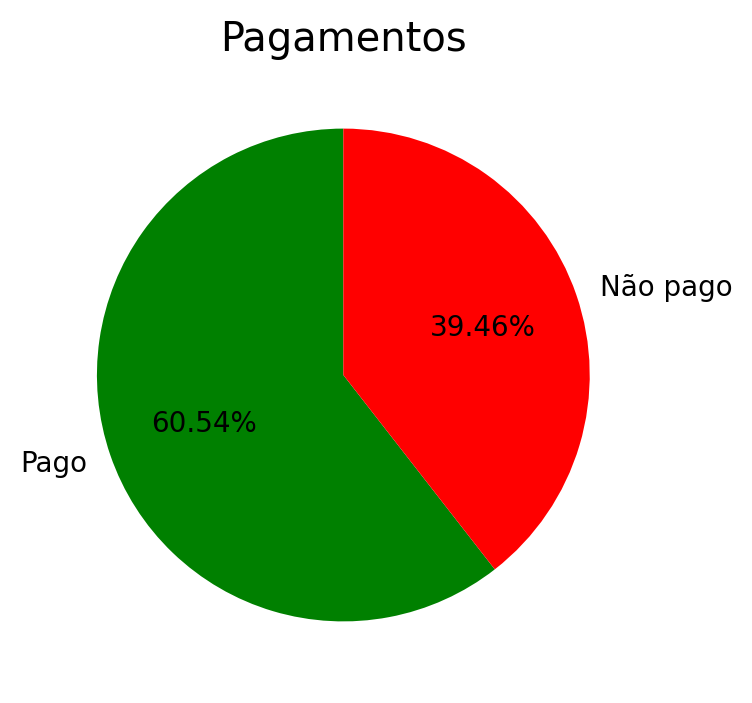

In [8]:
def chat_pay():
    # Create a sample DataFrame
    # Get the value counts of the 'Status' column
    df['Status'] = np.where (df ['Status'] == 1, "Pago", 'Não pago')
    status_counts = df['Status'].value_counts()
    # Create a pie chart
    colors = ['green','red']
    plt.figure(figsize=(4,4))
    status_counts.plot.pie(autopct='%.2f%%', startangle=90, colors = colors)
    plt.title('Pagamentos')
    plt.ylabel('')
    plt.show()

chat_pay()

Os dados sobre o tempo de pagamento indicam uma média de 213 dias, com um desvio padrão de 107,07. O menor intervalo de pagamento registrado foi de 12 dias, enquanto o maior foi de 426 dias, o limite estabelecido.

Ao analisar o gráfico, observa-se um pico notável em torno de 100 dias para o pagamento, porém, há uma longa cauda à direita, indicando que a distribuição não é normal.

In [9]:
df = df[(df['Status'] == "Pago") & (df['Periodo pagamento'] <=426)]
df['Periodo pagamento'].describe().round(2).to_frame()

,Periodo pagamento
count,2819.00
mean,213.19
std,107.07
min,12.00
25%,115.00
50%,198.00
75%,303.00
max,426.00


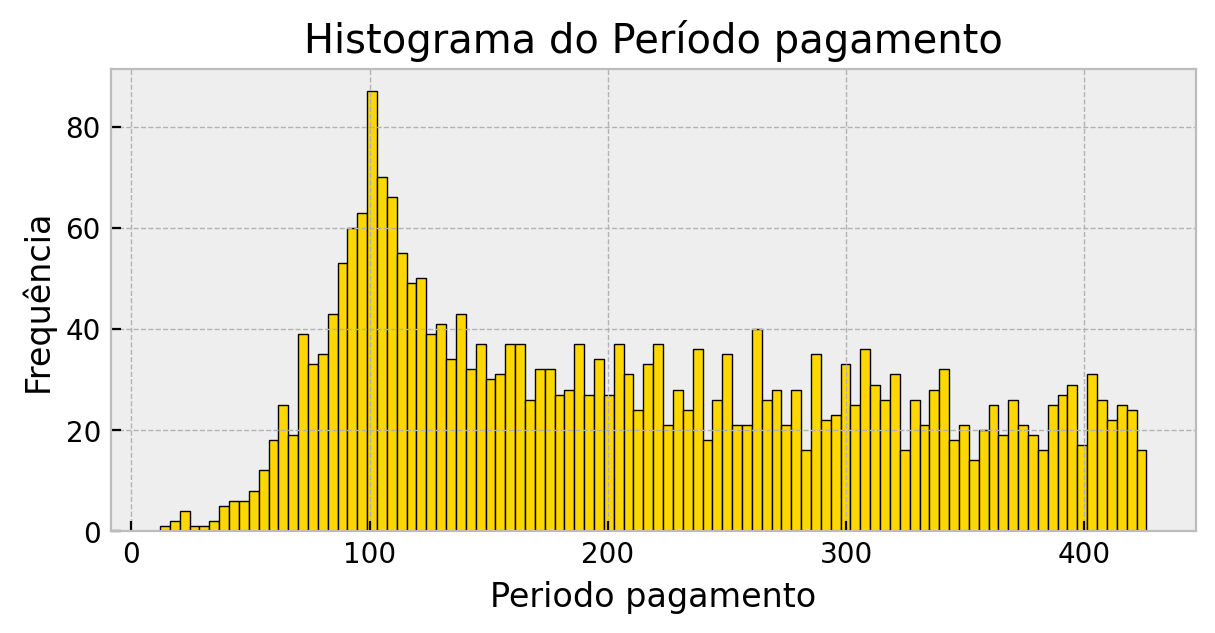

In [10]:
def plot_histogram_old(df):
    plt.figure(figsize=(7,3))
    plt.hist(df['Periodo pagamento'], bins=100, color='gold', edgecolor='black')

    # Add labels and title

    plt.xlabel('Periodo pagamento')
    plt.ylabel('Frequência')
    plt.title('Histograma do Período pagamento')

    # Show the histogram
    plt.show()

plot_histogram_old(df)

A diferença de dias no pagamento em relação ao vencimento afeta diretamente o valor a ser recolhido. Aqueles que quitam a multa antes do vencimento recebem um desconto de 20%. No entanto, o atraso no pagamento acarreta em acréscimo percentual diário. Como resultado, tem-se que a média da diferença no valor pago e valor da infração foi de -6,36 reais, com um máximo de 87,27 reais. O maior desconto foi de -293,47 reais.

In [11]:
df['diff_pay'] = df['Valor pago'] - df['NR_VALOR']
df['diff_pay'].describe().round(2).to_frame()

,diff_pay
count,2819.00
mean,-6.36
std,23.32
min,-293.47
25%,-26.03
50%,1.97
75%,5.09
max,87.27


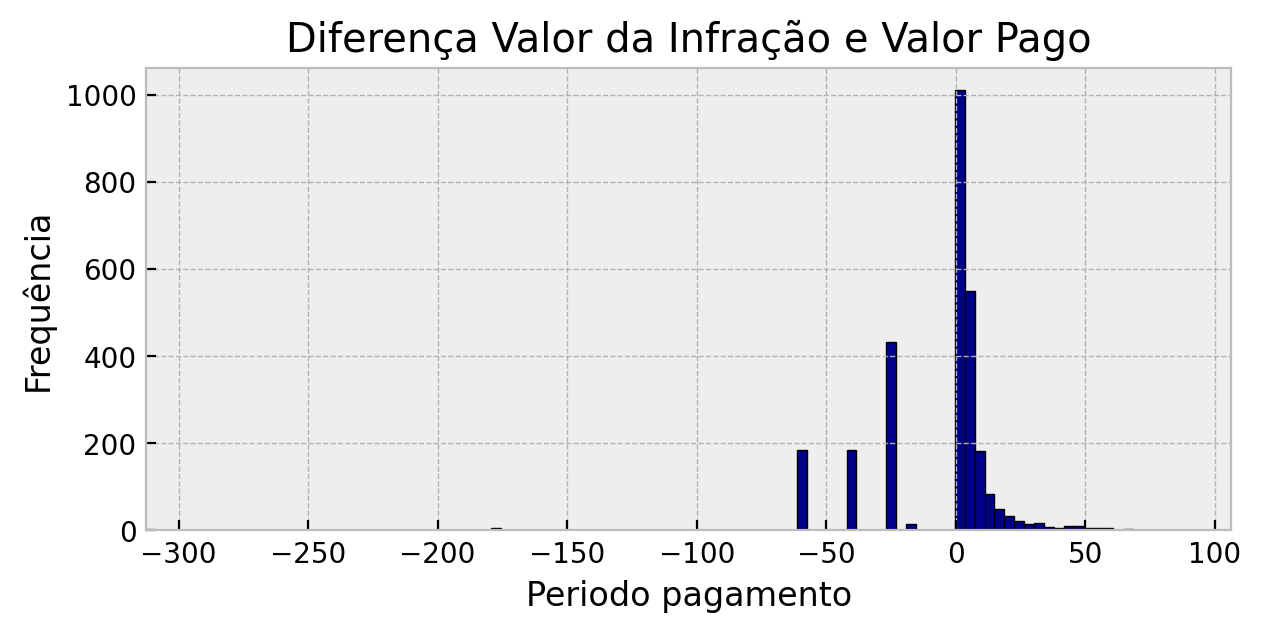

In [12]:
def diff_old_pay_histogram(df):
    df1 = df[df['Valor pago'] != 0]
    plt.figure(figsize=(7,3))
    plt.hist(df1['diff_pay'], bins=100, color='darkblue', edgecolor='black')

    # Add labels and title

    plt.xlabel('Periodo pagamento')
    plt.ylabel('Frequência')
    plt.title('Diferença Valor da Infração e Valor Pago')

    # Show the histogram
    plt.show()

diff_old_pay_histogram(df)

A análise desses dados envolveu o cálculo da proporção de multas pagas em até 60 dias em relação às multas com prazo máximo de 426 dias. Os resultados revelaram que apenas 2,16% das multas foram pagas durante esse intervalo de tempo.


In [13]:
df['pay_60'] = np.where(df[df['Valor pago'] != 0]['Periodo pagamento'] <=60, 1, 0)
round(df['pay_60'].value_counts(normalize=True) * 100,2)

pay_60
0    97.84
1     2.16
Name: proportion, dtype: float64


Agora, serão apresentados os dados com a introdução do SNE.

# Situação 1ª ano de SNE

A implementação do SNE teve impactos significativos na arrecadação das multas de trânsito. A média do tempo de pagamento diminuiu para 134 dias, representando uma redução de 79 dias em relação ao período anterior ao SNE. O desvio padrão também diminuiu, passando para 74,21 em comparação aos 107,07 anteriores à implementação do sistema. O menor valor registrado foi 0, indicando que alguns infratores pagaram a multa no mesmo dia da infração. Além disso, a mediana reduziu de 198 para 113 dias.

Com a adesão ao SNE, houve uma antecipação das receitas, refletindo-se na distribuição com um deslocamento do pico para a esquerda. Isso demonstra que os pagamentos, que originalmente levariam mais tempo para ocorrer, aconteceram mais rapidamente. Outro ponto importante é o aumento no número de pagamentos. Em apenas um ano, o índice de multas pagas está próximo ao valor anterior, e algumas projeções sugerem um aumento total dos pagamentos.

In [14]:
merged_df = pd.merge(df_all, df_pay, left_on='N. Auto', right_on='Número Auto')  # Change 'how' if needed
merged_df['Cometimento'] = merged_df['Cometimento'].apply(lambda x:x.replace(hour=00,minute=0,second=0))
merged_df['Periodo pagamento'] = (merged_df['Data Pagamento'] - merged_df['Cometimento']).dt.days
merged_df['Periodo pagamento'].describe().round(2).to_frame()

,Periodo pagamento
count,76772.00
mean,134.01
std,74.21
min,0.00
25%,85.00
50%,113.00
75%,172.00
max,426.00


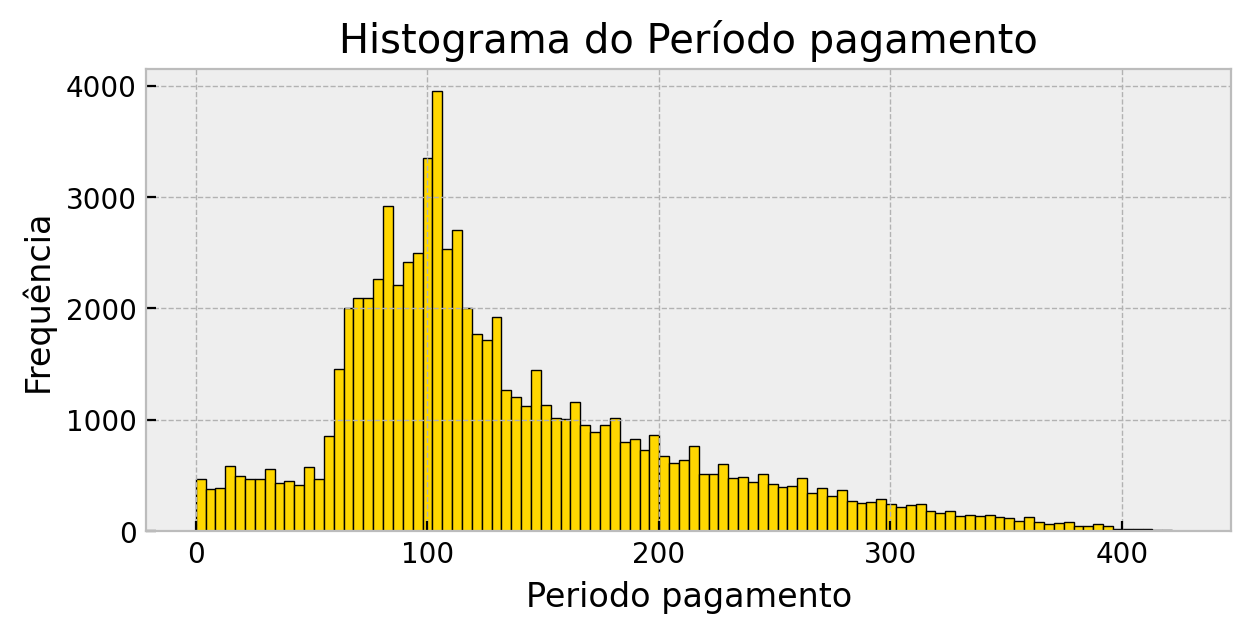

In [15]:
def plot_histogram_new(df):
    plt.figure(figsize=(7,3))
    plt.hist(merged_df['Periodo pagamento'], bins=100, color='gold', edgecolor='black')

    # Add labels and title

    plt.xlabel('Periodo pagamento')
    plt.ylabel('Frequência')
    plt.title('Histograma do Período pagamento')

    # Show the histogram
    plt.show()

plot_histogram_new(df)

Essa diminuição refletiu na redução do valor médio pago pelas infrações em relação ao seu valor real, registrando uma diferença média de 30,96 reais. Isso representa uma redução de cinco vezes em comparação ao período anterior ao SNE, onde o desconto médio atingia  586,94 reais. Em resumo, os infratores estão pagando menos pelas infrações cometidas

In [16]:
merged_df['Valor Pago'] = merged_df['Valor Pago'].str.replace('R$', '')
merged_df['Valor Pago'] = merged_df['Valor Pago'].str.replace('.', '')
merged_df['Valor Pago'] = merged_df['Valor Pago'].str.replace(',', '.')
merged_df['Valor'] = merged_df['Valor'].str.replace(',', '')


merged_df['Valor Pago'] = merged_df['Valor Pago'].astype(float)
merged_df['Valor'] = merged_df['Valor'].astype(float)
merged_df['Diff_pay'] = merged_df['Valor Pago'] - merged_df['Valor']
merged_df['Diff_pay'].describe().round(2).to_frame()

,Diff_pay
count,69659.00
mean,-30.96
std,35.94
min,-586.94
25%,-52.06
50%,-26.03
75%,1.30
max,79.60


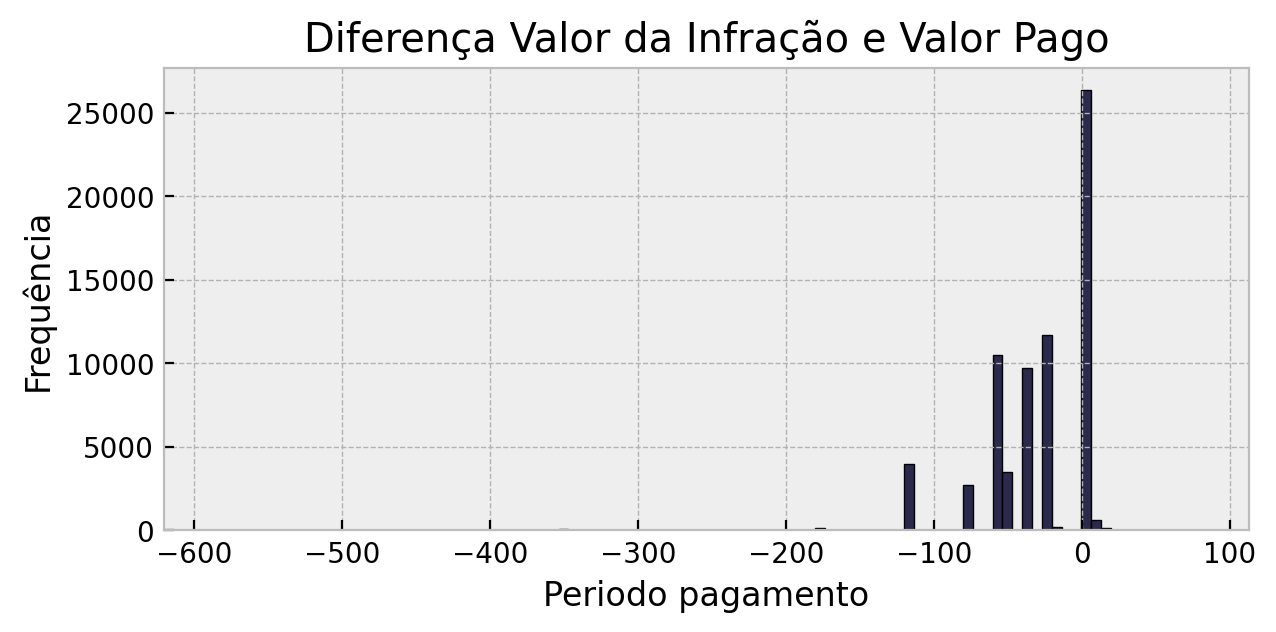

In [17]:
def diff_new_pay_histogram(df):
    plt.figure(figsize=(7, 3))
    plt.hist(merged_df['Diff_pay'], bins=100, color='#2B2A4C', edgecolor='black')

    # Add labels and title

    plt.xlabel('Periodo pagamento')
    plt.ylabel('Frequência')
    plt.title('Diferença Valor da Infração e Valor Pago')

    # Show the histogram
    plt.show()

diff_new_pay_histogram(df)

Uma informação relevante é o aumento significativo no percentual de multas pagas em até 60 dias, que saltou de 2,5% para 9,5%. A introdução do SNE teve um impacto notável ao antecipar as receitas do órgão, facilitando o pagamento para aqueles que cometem infrações de trânsito.

In [18]:
merged_df['pay_60'] = np.where(merged_df['Periodo pagamento'] <=60, 1, 0)
round(merged_df['pay_60'].value_counts(normalize=True) * 100,2)

pay_60
0    90.5
1     9.5
Name: proportion, dtype: float64

# Testes comparativos

Por fim, realizou-se o teste de Kolmogorov-Smirnov para comparar as distribuições acumuladas do tempo de pagamento antes e após a implementação do SNE. A análise da curva de densidade revela um aumento nos pagamentos em torno dos 100 dias, além de um achatamento na curva do lado direito. Visualmente, é possível perceber essa mudança, e o teste estatístico confirmou tal observação. As hipóteses testadas são:

- $H_{0}$: As distribuições acumuladas são iguais.
- $H_{1}$: As distribuições acumuladas não são iguais.
Com um nível de significância de 95%, o p-valor rejeita a hipótese nula. Concluímos, portanto, que as distribuições são diferentes.

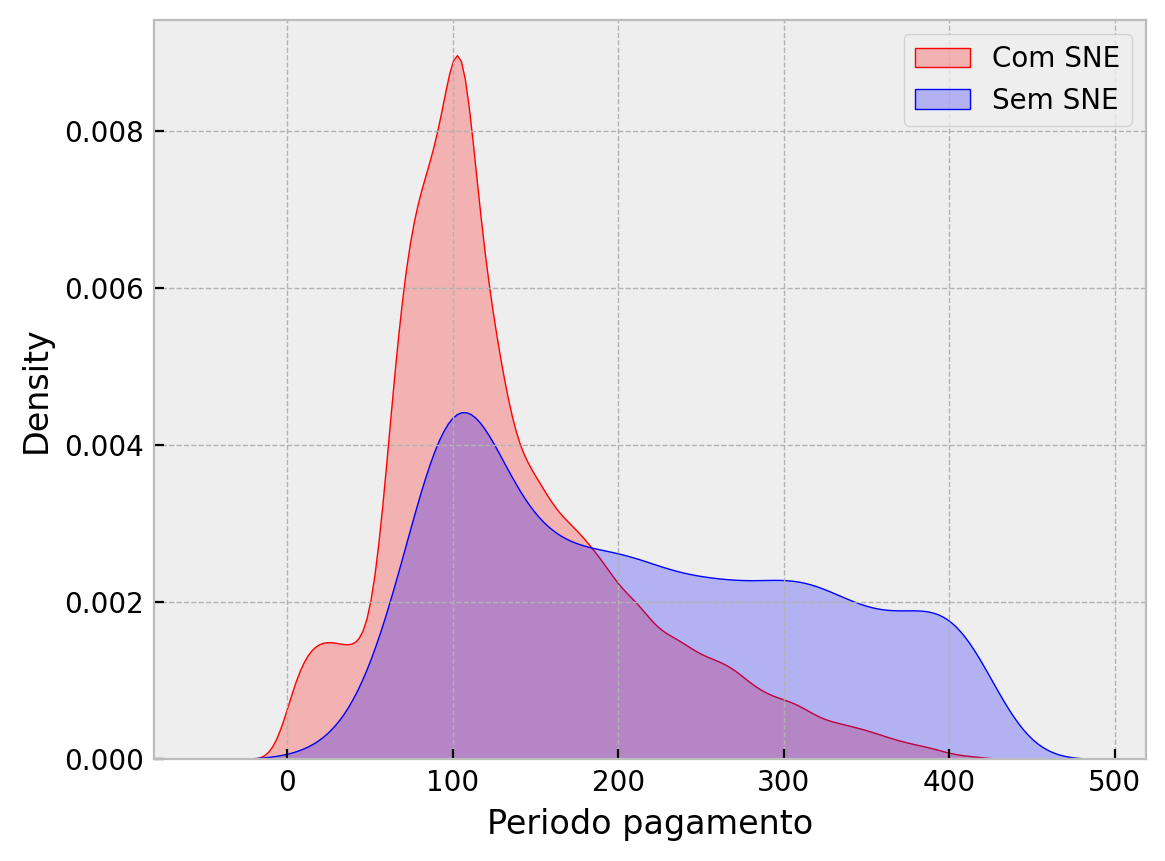

In [24]:
fig = sns.kdeplot(merged_df['Periodo pagamento'], shade=True, color="r")
fig = sns.kdeplot(df['Periodo pagamento'], shade=True, color="b")

legend_labels = ['Com SNE', 'Sem SNE']
plt.legend(legend_labels)
plt.show()

In [20]:
ks_stat, pvalor = stats.ks_2samp(merged_df['Periodo pagamento'], df['Periodo pagamento'])

In [21]:
print('p-valor:',  pvalor)

p-valor: 5.476616842729217e-249


"Portanto, a adesão ao SNE representou uma mudança significativa na arrecadação do órgão. Será necessário reajustar o orçamento para contemplar um recebimento mais ágil. Apesar da necessidade de readequação, os impactos dessa mudança foram benéficos.